# Task 5: Learning crowd dynamics

In [1]:
from utils import *

% matplotlib inline
%load_ext autoreload
%autoreload 2

## Part 1: 
We first load and explore the data.

In [2]:
data = pd.read_csv('MI_timesteps.txt', sep = ' ')
data

,timeStep,areaDensityCounting-PID5,areaDensityCounting-PID6,areaDensityCounting-PID7,areaDensityCounting-PID8,areaDensityCounting-PID9,areaDensityCounting-PID10,areaDensityCounting-PID11,areaDensityCounting-PID12,areaDensityCounting-PID13
0,1,36,0,0,0,0,0,0,0,0
1,2,36,0,0,0,0,0,0,0,0
2,3,43,0,0,0,0,0,0,0,0
3,4,49,0,0,0,0,0,0,0,0
4,5,59,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
14996,14997,0,10,95,4,0,0,2,1,39
14997,14998,0,10,94,3,0,0,3,1,39
14998,14999,0,10,93,3,0,1,2,1,40
14999,15000,0,10,93,3,0,1,3,1,41


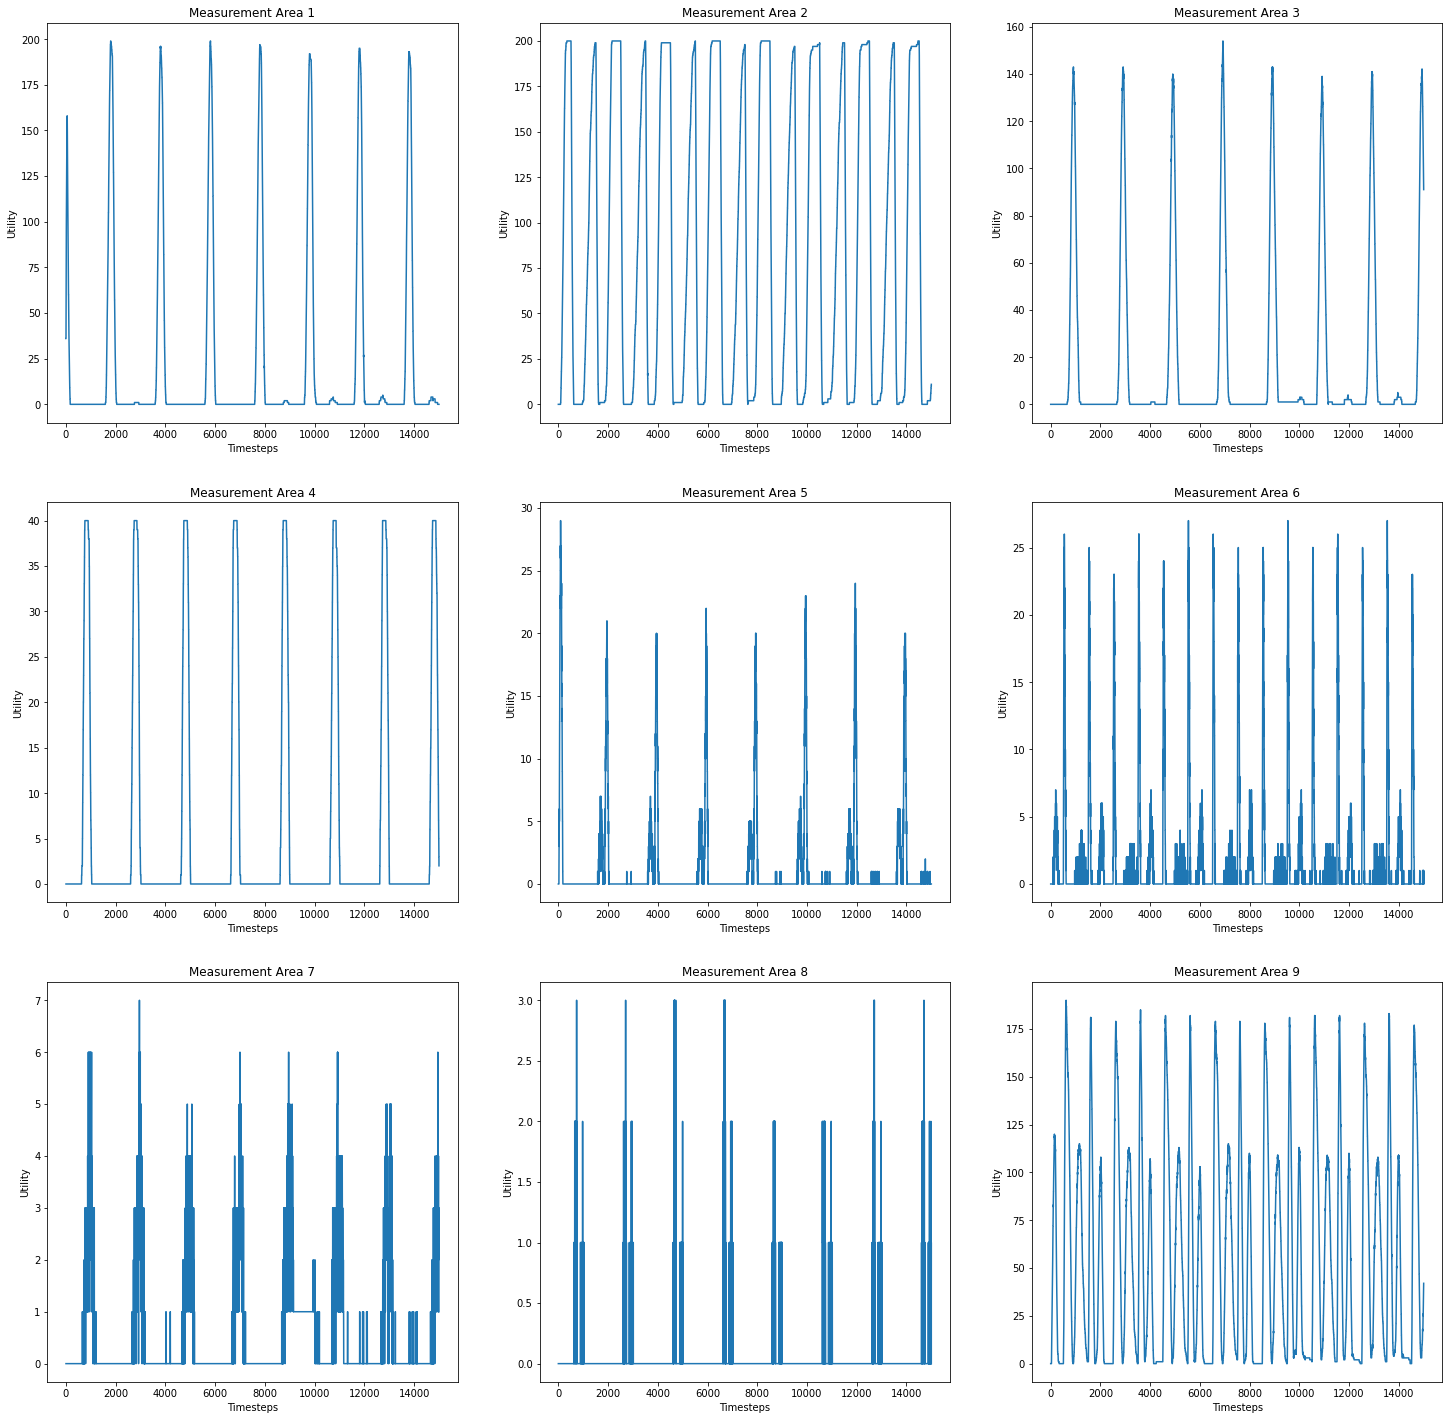

In [3]:
data = np.array(data)
# create a 3x3 plot
plot = plt.figure(figsize=(25,25))
# loop over all 9 measurement areas
for i in range(1,10):    
    # add the 5x5 3D subplot for the measurement area
    ax = plot.add_subplot(3,3,i)
    ax.plot(data[:,0],data[:,i])
    ax.set_title(f'Measurement Area {i}')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Utility')

Here we rearrange the shape of data by creating windows with smaller sizes.

In [4]:
# skip the unstable rows and the heading at the beginning
data = data[100:]

# create windows of 351 × 3 coordinates
delay = 351
n_windows = data.shape[0] - delay
# iterate the window over the data and flatten it to 1D
windows = np.zeros((n_windows, 3*delay))
for i in range(n_windows):
    windows[i] = data[i:i+delay, 1:4].flatten()

windows.shape

(14550, 1053)

We test the Explained Variance by Components using different number of components, so as to select a most suitable parameter.

Text(0, 0.5, 'Cumulative Explained Variance')

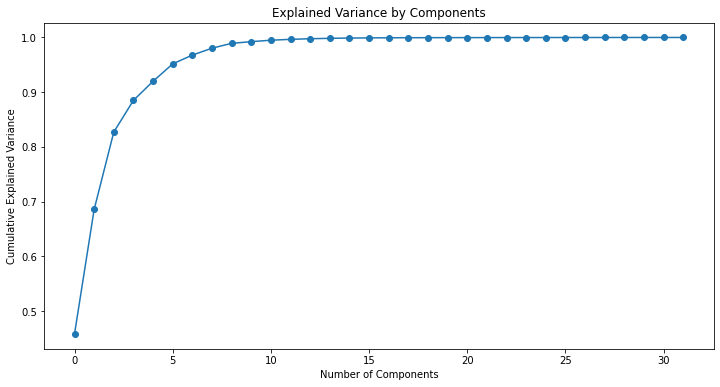

In [5]:
# Test PCA's performance for different number of principle components
pca = PCA(n_components = 32)
pc = pca.fit(windows)
plt.figure(figsize = (12, 6))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

By which we can see that only using 3 principal components can we represent the state of the system with 83% of the energy now.

In [6]:
pca = PCA(n_components = 3)
pc = pca.fit(windows)
energy_captured = pc.explained_variance_ratio_.sum()*100
reconstructed_windows = pc.transform(windows)
print(reconstructed_windows.shape)
print(energy_captured)

(14550, 3)
82.71115175763506


f:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


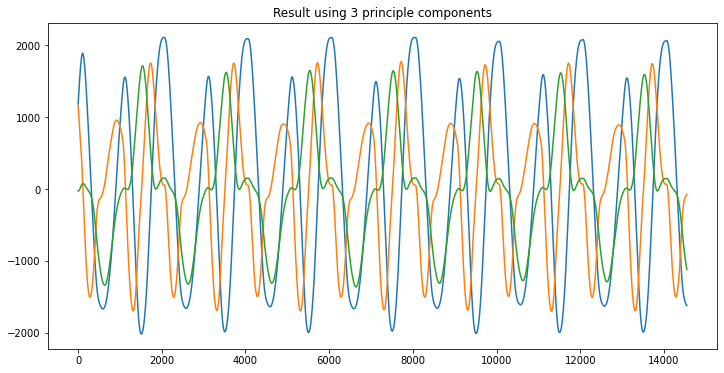

In [7]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(reconstructed_windows)
ax.set_title('Result using 3 principle components')
fig.show()

We can also plot the result in 3D space with each dimensions representing one principle component.

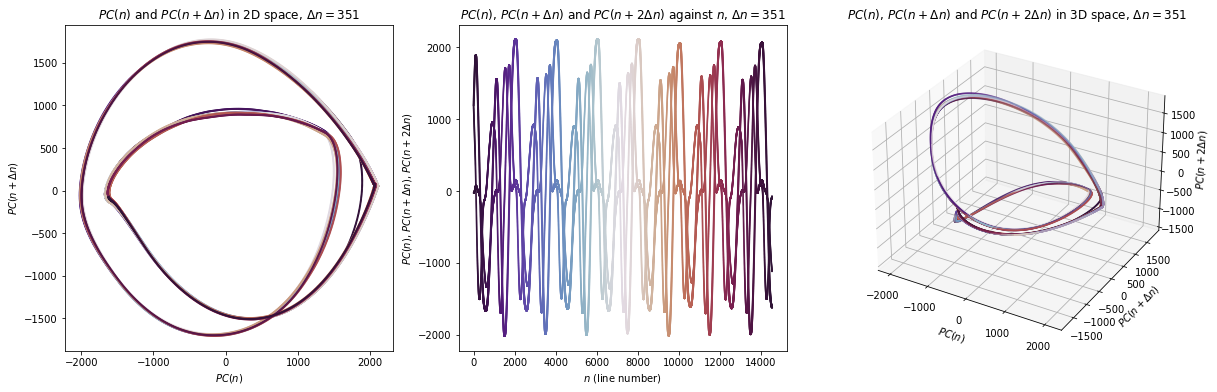

In [8]:
index = range(len(reconstructed_windows.T[0]))
plot_shift((reconstructed_windows.T, index), 'PC', delay)

## Part 2:
For the second part we color the data points by all measurements taken at the first time point of the delays into 9 plots where all the points will be in the same position, only the color changes. 

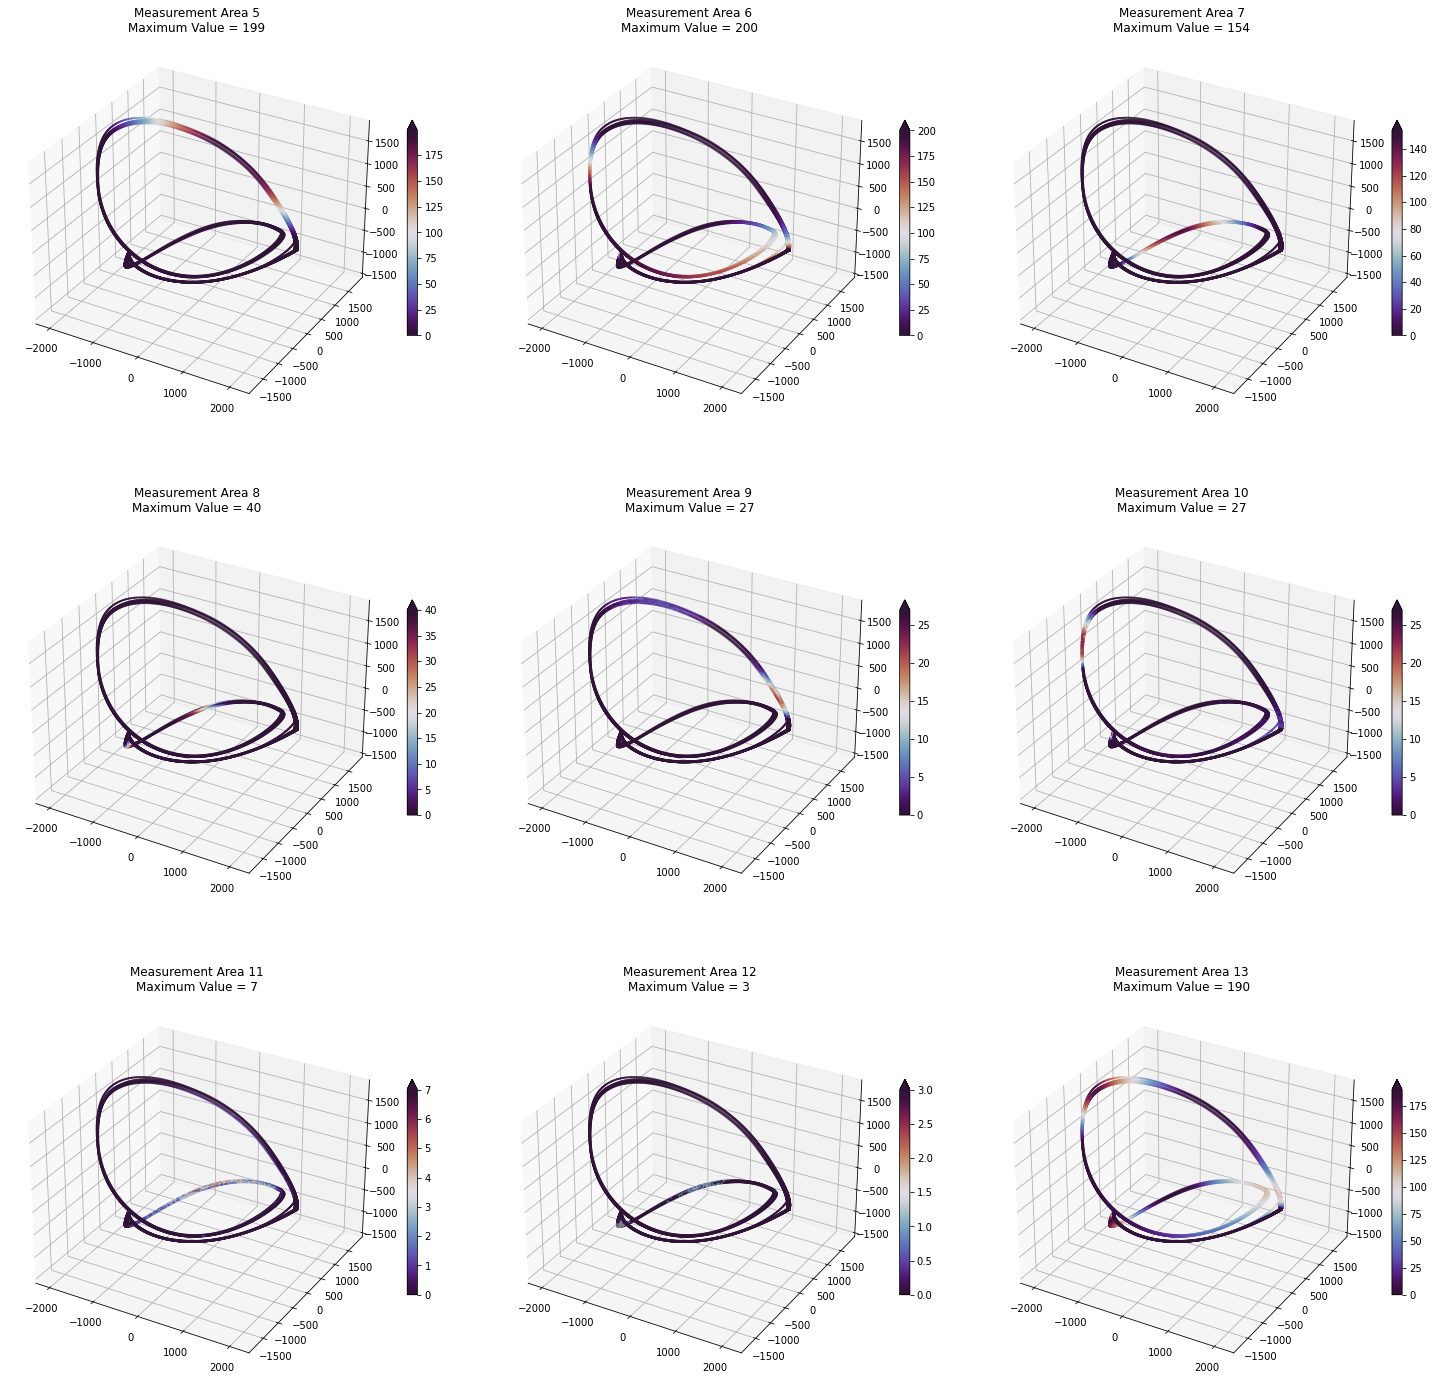

In [9]:
fig = plt.figure(figsize=(25,25))
# loop over all 9 measurement areas
for count in range(1,10):
    #add the 5x5 3D subplot for the measurement area
    ax = fig.add_subplot(3, 3, count, projection='3d')
    ax.set_title(f"Measurement Area {count+4}\nMaximum Value = {np.max(data[:,count])}")
    #plot all three principal components and use the measurement point as color map
    subplot = ax.scatter(reconstructed_windows[:,0], reconstructed_windows[:,1], reconstructed_windows[:,2], s=1, c=data[:-delay,count], cmap=plt.cm.twilight_shifted)
    fig.colorbar(subplot,fraction=0.025,extend='max')

## Part 3

In this part we want to learn the dynamics on the periodic curve we embedded in the principal components above by computing the arc length of the curve in the PCA space and then approximate the change of arc length over time. By observing PCA's result we can tell that a periodicity around every 2000 time step (row numbers) exists for all three components. Hence we calculate the velocity of the arc length by determining how fast the system advances over the PCA space at every point in the space, and then approximate the change in arc length over time. We do this by comparing each time step with the previous one.

Text(0, 0.5, 'velocity (vector field)')

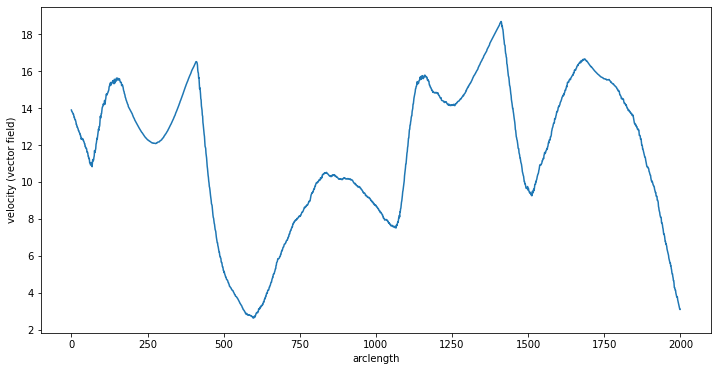

In [10]:
# Calculate velocity
velocity_length = np.zeros((windows.shape[0],1))
for i in range(windows.shape[0]-1):
    velocity_length[i] = np.linalg.norm(reconstructed_windows[i]-reconstructed_windows[i+1])
velocity_length[-1]=velocity_length[-2]

period = 2000

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(velocity_length[:2000])
ax.set_xlabel('arclength')
ax.set_ylabel('velocity (vector field)')

RBF approximation

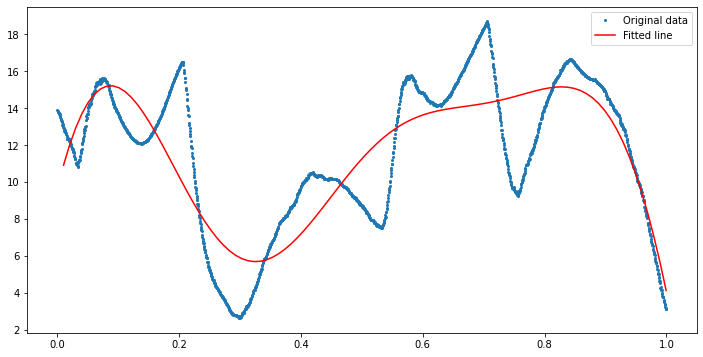

In [81]:
count = 2000
index = np.arange(count, dtype=np.float64)/count

x = index
y = velocity_length[:count]
x_min = np.min(x)
x_max = np.max(x)
L =  100
domain = np.linspace(x_min, x_max, L)
eps = 0.2
phi = RBF(eps, domain)

x_phi = phi(x[0])
for i in range(1, len(x)):
    x_phi = np.vstack((x_phi, phi(x[i])))
C, _, _, _ = LSM(x_phi, y)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(x, y, 'o', label='Original data', markersize=2)
fitting_x = np.linspace(x_min, x_max, L)
fitting_y = np.array(C.T @ phi(fitting_x))
for i in range(1, len(fitting_x)):
    fitting_y = np.vstack((fitting_y, C.T @ phi(fitting_x[i])))
ax.plot(fitting_x[1:], fitting_y[1:], 'r', label='Fitted line', markersize=1)
ax.legend()